# Visualize the results

In [1]:
import os, re
import util
import pandas as pd
import numpy as np
import tensorflow as tf
print 'tensorflow version:', tf.__version__

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

tensorflow version: 1.0.1


## Plot Embeddings

In [2]:
def restore_emb(config):
    print 'Restoring graph...',
    with tf.Graph().as_default():
        with tf.variable_scope('cnn'):
            if config.has_key('contextwise') and config['contextwise']:
                import cnn_context
                m = cnn_context.Model(config, is_train=False)
            else:
                import cnn
                m = cnn.Model(config, is_train=False)
        saver = tf.train.Saver(tf.global_variables())

        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(config['train_dir'])
            saver.restore(sess, ckpt.model_checkpoint_path)
            
            embeddings = sess.run(tf.global_variables())
    print 'done.'        
    if config.has_key('contextwise') and config['contextwise']:
        return embeddings[:3]
    else:
        return embeddings[0]

In [3]:
def get_2d_emb(embeddings, limit=None):
    print 'Reducing dimension...',
    if limit:
        embeddings = embeddings[2:limit+2] # skip <pad> and <unk>
    norm = np.sqrt(np.sum(np.square(embeddings), axis=0))
    normalized_embeddings = embeddings / norm
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    two_d_embeddings = tsne.fit_transform(normalized_embeddings)
    print 'done.'
    return two_d_embeddings

In [4]:
def construct_emb_df(data_dir, two_d_embeddings):
    print 'Loading vocabulary...',
    vocab_path = os.path.join(data_dir, 'vocab.txt')
    word2id, _ = util.initialize_vocabulary(vocab_path)
    limit = len(two_d_embeddings)
    keys, values = word2id.keys()[2:limit+2], word2id.values()[2:limit+2]
    word = pd.DataFrame({'word': keys}, index=values)
    values = pd.DataFrame(two_d_embeddings, columns=['x', 'y'])
    emb_df = pd.concat([word, values], axis=1)
    emb_df = emb_df[pd.notnull(emb_df.x)]
    print 'done.'
    return emb_df

In [5]:
def merge_id(emb_df, lower=True):
    print 'Merging ids...',
    positive_df = pd.read_csv(os.path.join(data_dir, '..', 'positive_relations.tsv'),
                           sep='\t', index_col=0, encoding='utf-8')
    subj = positive_df[['subj', 'subj_qid']].rename_axis(
        {"subj": "entity", "subj_qid": "id"}, axis="columns")
    obj = positive_df[['obj', 'obj_qid']].rename_axis(
        {"obj": "entity", "obj_qid": "id"}, axis="columns")
    rel = positive_df[['rel', 'rel_id']].rename_axis(
        {"rel_id": "id"}, axis="columns")
    entity = pd.concat([subj, obj, rel], axis=0, ignore_index=True)
    if lower:
        entity['word'] = ['<' + w.lower() + '>' for w in entity['id']]
    else:
        entity['word'] = ['<' + w + '>' for w in entity['id']]
    entity = entity.drop_duplicates('word')
    merge_emb_df = emb_df.merge(entity[['entity', 'rel', 'word']], how='outer', on='word')
    print 'done.'
    return merge_emb_df

In [6]:
def plot_emb(dfs, colors, labels, anno=None, limit=None, 
             title='Embeddings', xlim=None, ylim=None):
    ax = dfs[0].plot(kind="scatter", 
            x='x', y='y', color=colors[0], legend=True, label=labels[0])
    ax = dfs[1].plot(kind="scatter", ax=ax, 
            x='x', y='y', color=colors[1], legend=True, label=labels[1])
    # annotate labels
    if anno:
        for index, row in dfs[1].iterrows():
            if limit and index % limit != 0:
                continue
            ax.annotate(row[anno], xy=(row['x'], row['y']))
            
    ax.set_xlabel('')
    ax.set_ylabel('')
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_title(title)
    fig = ax.get_figure()
    return fig

### ER-CNN

Restoring graph... done.
Reducing dimension... done.
Loading vocabulary... done.
Merging ids... done.


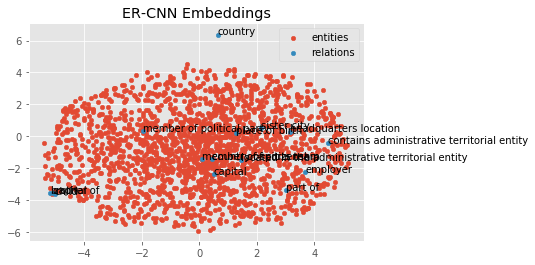

In [16]:
train_dir = os.path.join(os.getcwd(), 'models', 'er-cnn')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
config['train_dir'] = train_dir
data_dir = config['data_dir']
colors = ['#E24A33', '#348ABD']
labels = ['entities', 'relations']

emb_er = restore_emb(config)
two_d_emb_er = get_2d_emb(emb_er, limit=5000)
df_er = construct_emb_df(data_dir, two_d_emb_er)
emb_df_er = merge_id(df_er, lower=False)
dfs_er = [emb_df_er[pd.notnull(emb_df_er.entity)], 
          emb_df_er[pd.notnull(emb_df_er.rel)]]
fig_er = plot_emb(dfs_er, colors, labels, anno='rel', limit=None, 
                  title='ER-CNN Embeddings')
fig_er.savefig(os.path.join('img', 'emb_er.svg'))

### MLMI-CNN

In [18]:
train_dir = os.path.join(os.getcwd(), 'models', 'mlmi-cnn')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
config['train_dir'] = train_dir
data_dir = config['data_dir']
colors = ['#E24A33', '#348ABD']
labels = ['words', 'entities']

emb_mlmi = restore_emb(config)

Restoring graph... done.


Reducing dimension... done.
Loading vocabulary... done.
Merging ids... done.


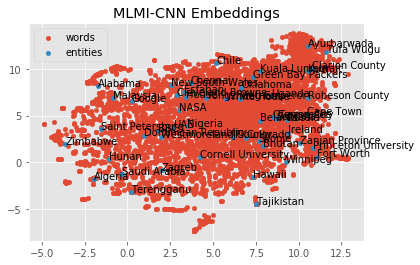

In [19]:
two_d_emb_mlmi = get_2d_emb(emb_mlmi, limit=5000)
df_mlmi = construct_emb_df(data_dir, two_d_emb_mlmi)
emb_df_mlmi = merge_id(df_mlmi, lower=True)
dfs_mlmi = [emb_df_mlmi[pd.isnull(emb_df_mlmi.entity)], 
            emb_df_mlmi[pd.notnull(emb_df_mlmi.entity)]]
fig_mlmi = plot_emb(dfs_mlmi, colors, labels, anno='entity', 
                    limit=None, title='MLMI-CNN Embeddings')
fig_mlmi.savefig(os.path.join('img', 'emb_mlmi.svg'))

### MLMI-CONT

In [7]:
train_dir = os.path.join(os.getcwd(), 'models', 'mlmi-cont')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
config['train_dir'] = train_dir
data_dir = config['data_dir']
colors = ['#E24A33', '#348ABD']
labels = ['words', 'entities']

embeddings = restore_emb(config)

Restoring graph... done.


Reducing dimension... done.
Loading vocabulary... done.
Merging ids... done.


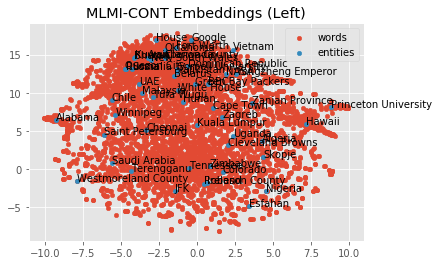

In [8]:
two_d_emb_left = get_2d_emb(embeddings[0], limit=5000)
emb_df_left = construct_emb_df(data_dir, two_d_emb_left)
emb_df_left = merge_id(emb_df_left, lower=True)
dfs_left = [emb_df_left[pd.isnull(emb_df_left.entity)], 
            emb_df_left[pd.notnull(emb_df_left.entity)]]
fig_left = plot_emb(dfs_left, colors, labels, anno='entity', 
                    limit=None, title='MLMI-CONT Embeddings (Left)')
fig_left.savefig(os.path.join('img', 'emb_left.svg'))

Reducing dimension... done.
Loading vocabulary... done.
Merging ids... done.


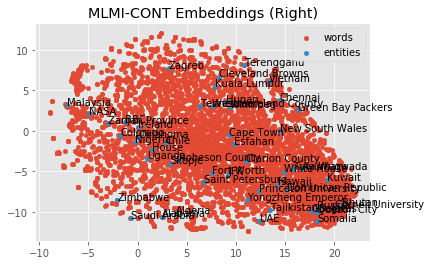

In [9]:
two_d_emb_right = get_2d_emb(embeddings[2], limit=5000)
emb_df_right = construct_emb_df(data_dir, two_d_emb_right)
emb_df_right = merge_id(emb_df_right, lower=True)
dfs_right = [emb_df_right[pd.isnull(emb_df_right.entity)], 
             emb_df_right[pd.notnull(emb_df_right.entity)]]
fig_right = plot_emb(dfs_right, colors, labels, anno='entity', 
                     limit=None, title='MLMI-CONT Embeddings (Right)')
fig_right.savefig(os.path.join('img', 'emb_right.svg'))

## Plot Precision-Recall Curve

In [9]:
def plot_pr_curve(train_dirs, colors, labels, xlim=None, ylim=None):
    
    for i, train_dir in enumerate(train_dirs):
        results = util.load_from_dump(os.path.join(train_dir, 'results.cPickle'))
        plt.plot(results['recall'], results['precision'], 'o-', 
                 color=colors[i], label=labels[i])
        
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    return plt

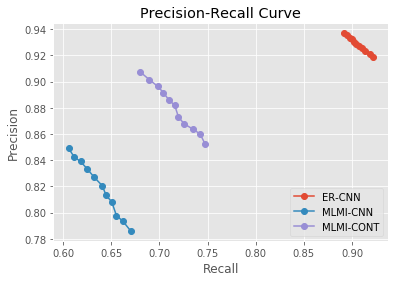

In [10]:
train_dirs = ['./models/er-cnn', './models/mlmi-cnn', './models/mlmi-cont']
colors = ['#E24A33', '#348ABD', '#988ED5']
labels = ['ER-CNN', 'MLMI-CNN', 'MLMI-CONT']
fig_auc = plot_pr_curve(train_dirs, colors, labels)
fig_auc.savefig(os.path.join('img', 'pr_curve.svg'))

## Classification report

In [12]:
train_dirs = ['./models/er-cnn', './models/mlmi-cnn', './models/mlmi-cont']
models = ['ER-CNN', 'MLMI-CNN', 'MLMI-CONT']
print '              P       R      F1      AUC '
for i, train_dir in enumerate(train_dirs):
    results = util.load_from_dump(os.path.join(train_dir, 'results.cPickle'))
    pre = results['precision'][5]
    rec = results['recall'][5]
    f1 = (2.0 * pre * rec) / (pre + rec)
    auc = util.calc_auc_pr(results['precision'], results['recall'])
    print '%9s  %.4f  %.4f  %.4f  %.4f' % (models[i], pre, rec, f1, auc)

              P       R      F1      AUC 
   ER-CNN  0.9290  0.9040  0.9163  0.9275
 MLMI-CNN  0.8205  0.6406  0.7195  0.7424
MLMI-CONT  0.8819  0.7158  0.7902  0.8156


In [2]:
def get_scores(config, data, train_dir):
    with tf.Graph().as_default():
        with tf.variable_scope('cnn'):
            if config.has_key('contextwise') and config['contextwise']:
                import cnn_context
                m = cnn_context.Model(config, is_train=False)
            else:
                import cnn
                m = cnn.Model(config, is_train=False)
        saver = tf.train.Saver(tf.global_variables())

        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(train_dir)
            saver.restore(sess, ckpt.model_checkpoint_path)
            
            predictions = []
            if config.has_key('contextwise') and config['contextwise']:
                left_batch, middle_batch, right_batch, y_batch, _ = zip(*data)
                feed = {m.left: np.array(left_batch),
                        m.middle: np.array(middle_batch),
                        m.right: np.array(right_batch),
                        m.labels: np.array(y_batch)}
            else:
                x_batch, y_batch, _ = zip(*data)
                feed = {m.inputs: np.array(x_batch), m.labels: np.array(y_batch)}
            prob = sess.run(m.scores, feed_dict=feed)
            for i in np.linspace(0, 1, 11):
                prediction = tf.where(prob > i, tf.ones_like(prob), tf.zeros_like(prob))
                predictions.append(prediction.eval())
            
    return np.array(predictions)

In [3]:
def report(y_true, y_pred, class_names):
    #y_pred = y_pred
    tp = np.logical_and(y_true, y_pred)
    fp = np.logical_and(np.logical_not(y_true), y_pred)
    fn = np.logical_and(y_true, np.logical_not(y_pred))
    pre = np.sum(tp.astype(float), axis=1)/np.sum(np.logical_or(tp, fp).astype(float), axis=1)
    rec = np.sum(tp.astype(float), axis=1)/np.sum(np.logical_or(tp, fn).astype(float), axis=1)
    f1 = (2.0 * pre * rec)/(pre + rec)
    count = np.sum(y_true, axis=0)
    auc_array = []
    ret = '          P \t  R \t  F1\t AUC\t  C\n'
    for i, (c, p, r, f, s) in enumerate(zip(class_names, pre[5], rec[5], f1[5], count)):
        auc = util.calc_auc_pr(pre[:, i], rec[:, i])
        auc_array.append(auc)
        ret += '%6s\t%.4f\t%.4f\t%.4f\t%.4f\t%4d\n' % (c, p, r, f, auc, s)
    
    auc = np.array(auc_array)
    p = pre[5, np.isfinite(pre[5])]*count[np.isfinite(pre[5])]
    r = rec[5, np.isfinite(rec[5])]*count[np.isfinite(rec[5])]
    f = f1[5, np.isfinite(f1[5])]*count[np.isfinite(f1[5])]
    a = auc[np.isfinite(auc)]*count[np.isfinite(auc)]
    ret += '%6s\t%.4f\t%.4f\t%.4f\t%.4f\t%4d\n' % ('total', 
         np.sum(p)/count.sum(dtype=float), 
         np.sum(r)/count.sum(dtype=float), 
         np.sum(f)/count.sum(dtype=float), 
         np.sum(a)/count.sum(dtype=float),
         count.sum())
    
    return ret

In [4]:
class_names = [u'P17', u'P131', u'P27', u'P47', u'P19', u'P150', u'P54', u'P20', 
               u'P1376', u'P69', u'P159', u'P530', u'P108', u'P26', u'P118', 
               u'P40', u'P36', u'P102', u'P361', u'P463', u'P190', u'P22', u'P7']

In [5]:
print '===== MLMI-CONT ====='
train_dir = os.path.join(os.getcwd(), 'models', 'mlmi-cnn')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
source_path = os.path.join(config['data_dir'], "ids.txt")
target_path = os.path.join(config['data_dir'], "target.txt")
_, data = util.read_data(source_path, target_path, config['sent_len'],
                         train_size=config['train_size'])

y_true = np.array([y[1] for y in data])
y_pred = get_scores(config, data, train_dir)
print report(y_true, y_pred, class_names)

MLMI-CNN
Loading data... 	11832 examples found.
Splitting data... 	10000 for train, 1832 for test
          P 	  R 	  F1	 AUC	  C
   P17	0.8419	0.8510	0.8464	0.8319	 651
  P131	0.8895	0.7090	0.7891	0.7860	 488
   P27	0.9054	0.4188	0.5726	0.6309	 160
   P47	0.7956	0.7956	0.7956	0.7869	 225
   P19	0.5263	0.3571	0.4255	0.5106	  56
  P150	0.7500	0.0800	0.1446	0.5152	  75
   P54	0.7407	0.7407	0.7407	0.7282	  27
   P20	0.6250	0.1923	0.2941	0.3723	  26
 P1376	0.5806	0.3158	0.4091	0.4605	  57
   P69	nan	0.0000	nan	nan	  22
  P159	0.7727	0.4857	0.5965	0.5811	  35
  P530	0.7115	0.7551	0.7327	0.6344	  49
  P108	1.0000	0.0714	0.1333	0.5357	  14
   P26	0.5455	0.2727	0.3636	0.4272	  22
  P118	1.0000	0.5926	0.7442	0.7047	  27
   P40	0.4000	0.1250	0.1905	0.2390	  16
   P36	nan	0.0000	nan	nan	  19
  P102	1.0000	0.0588	0.1111	nan	  17
  P361	0.1333	0.2222	0.1667	0.1753	   9
  P463	0.8333	0.3333	0.4762	0.5778	  15
  P190	nan	0.0000	nan	nan	   7
   P22	nan	0.0000	nan	nan	  10
    P7	1.0000	0.1429	0.2500	n

In [21]:
print '===== MLMI-CONT ====='
train_dir = os.path.join(os.getcwd(), 'models', 'mlmi-cont')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
source_path = os.path.join(config['data_dir'], "ids")
target_path = os.path.join(config['data_dir'], "target.txt")
_, data = util.read_data_contextwise(source_path, target_path, config['sent_len'], 
                                     train_size=config['train_size'])

y_true = np.array([y[3] for y in data])
y_pred = get_scores(config, data, train_dir)
print report(y_true, y_pred, class_names)

MLMI-CONT
Loading data... 	11832 examples found.
Splitting data... 	10000 for train, 1832 for test
          P 	  R 	  F1	 AUC	  C
   P17	0.9179	0.9278	0.9228	0.9079	 651
  P131	0.9074	0.7029	0.7921	0.7886	 488
   P27	0.6954	0.6562	0.6752	0.6466	 160
   P47	0.8906	0.7600	0.8201	0.8011	 225
   P19	0.8182	0.3214	0.4615	0.5591	  56
  P150	0.9773	0.5733	0.7227	0.7693	  75
   P54	1.0000	0.4444	0.6154	0.6404	  27
   P20	1.0000	0.1154	0.2069	0.5385	  26
 P1376	0.8837	0.6667	0.7600	0.7656	  57
   P69	0.9091	0.4545	0.6061	0.6032	  22
  P159	0.8095	0.4857	0.6071	0.6129	  35
  P530	0.8333	0.8163	0.8247	0.7977	  49
  P108	nan	0.0000	nan	nan	  14
   P26	1.0000	0.2273	0.3704	0.6136	  22
  P118	0.8966	0.9630	0.9286	0.9154	  27
   P40	0.6250	0.3125	0.4167	0.4657	  16
   P36	nan	0.0000	nan	nan	  19
  P102	0.8182	0.5294	0.6429	0.6733	  17
  P361	0.2000	0.1111	0.1429	0.1556	   9
  P463	1.0000	0.3333	0.5000	0.6667	  15
  P190	nan	0.0000	nan	nan	   7
   P22	nan	0.0000	nan	nan	  10
    P7	0.2000	0.1429	0.16

## Plot Train Log

In [22]:
def plot_log(train_dirs, colors, models, name, xlim=None, ylim=None):
    
    fig, ax = plt.subplots(1, 1)
    for i, train_dir in enumerate(train_dirs):
        train = pd.read_csv(os.path.join(train_dir, 'train_%s.csv' % name),
            index_col=1, names=['time', 'train_%s' % models[i]], skiprows=[0])
        dev = pd.read_csv(os.path.join(train_dir, 'dev_%s.csv' % name), 
            index_col=1, names=['time', 'dev_%s' % models[i]], skiprows=[0])      
        
        ax = train['train_%s' % models[i]].plot(style='--', legend=True, 
                                                color=colors[i], ax=ax)
        ax = dev['dev_%s' % models[i]].plot(legend=True, 
                                            color=colors[i], ax=ax)
        ax.set_xlabel('Step')
        ax.set_ylabel(name.upper())
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        ax.set_title(name.upper())
    return fig

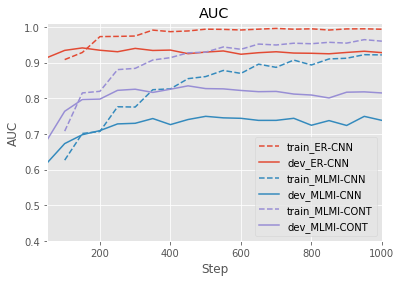

In [26]:
train_dirs = ['./models/er-cnn', './models/mlmi-cnn', './models/mlmi-cont']
colors = ['#E24A33', '#348ABD', '#988ED5']
models = ['ER-CNN', 'MLMI-CNN', 'MLMI-CONT']
fig_auc = plot_log(train_dirs, colors, models, 'auc', xlim=(50, 1000), ylim=(0.4, 1.01))
fig_auc.savefig(os.path.join('img', 'auc.svg'))

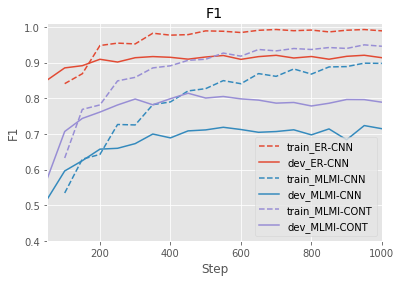

In [27]:
fig_f1 = plot_log(train_dirs, colors, models, 'f1', 
                  xlim=(50, 1000), ylim=(0.4, 1.01))
fig_f1.savefig(os.path.join('img', 'f1.svg'))

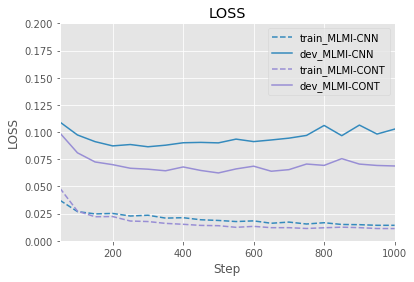

In [33]:
train_dirs = ['./models/mlmi-cnn', './models/mlmi-cont']
colors = ['#348ABD', '#988ED5']
models = ['MLMI-CNN', 'MLMI-CONT']
fig_loss = plot_log(train_dirs, colors, models, 'loss', ylim=(0, 0.2))
fig_loss.savefig(os.path.join('img', 'loss.svg'))